In [28]:
import matplotlib.pyplot as plt
from networkx import nx
from networkx.readwrite import json_graph
import json
import random as rn
import numpy as np
from numpy.random import choice as np_choice

# Создаем и сохраняем граф
Создаем и записываем граф в файл, это необходимо, чтобы тестировать и обучать популяции по Ламарку и по Дарвину можно было в одинаковых условиях (на одинаковых графах).

Также было принято решение отказаться от направленного графа для упрощения задачи. Сложность вызвало создание направленного графа в котором гарантировано будет хотя бы один маршрут из точки А в точку Б.*Курсив*

In [2]:
def generate_graph(_iteration_number):
  n = 10  # TODO: 1024 nodes
  m = 30  # от N до 3xN ???
  general_graph = nx.gnm_random_graph(n, m, directed=False)
  export_graph = json_graph.node_link_data(general_graph)
  with open('/content/sample_data/darvin_graph_'+iteration_number+'.json', 'w') as writefile:
    writefile.write(json.dumps(export_graph))

In [77]:
iteration_number = '10'
#generate_graph(iteration_number)

0
[(0, 7), (0, 6), (0, 3), (0, 2), (0, 5), (0, 1)]
1
[(1, 0), (1, 9), (1, 7), (1, 8), (1, 5), (1, 3)]
2
[(2, 0), (2, 8), (2, 5), (2, 6), (2, 9)]
3
[(3, 0), (3, 1), (3, 9), (3, 7), (3, 4), (3, 6)]
4
[(4, 3), (4, 9), (4, 8), (4, 5)]
5
[(5, 0), (5, 1), (5, 2), (5, 4), (5, 8), (5, 6), (5, 7), (5, 9)]
6
[(6, 0), (6, 2), (6, 3), (6, 5), (6, 7), (6, 8)]
7
[(7, 0), (7, 1), (7, 3), (7, 5), (7, 6), (7, 8)]
8
[(8, 1), (8, 2), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9)]
9
[(9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 8)]


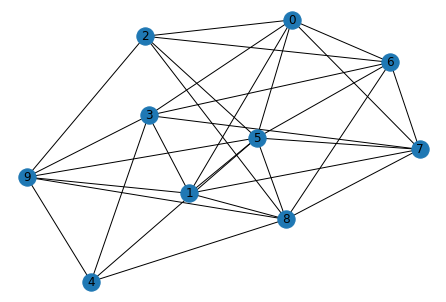

In [76]:
# Считываем граф из файла
file_name = "darvin_graph_"+iteration_number+".json"
g = nx.DiGraph()
with open('/content/sample_data/'+file_name, 'r') as readfile:
  js_graph = json.load(readfile)
  g = json_graph.node_link_graph(js_graph, directed=True)

# итерация узлов
for i in range(0, len(g.nodes)):
  print(i)
  print(g.edges(i))


# Рисуем граф если граф тестовый (граф из 1024 точек адекватно не отображается)
if len(g.nodes)<50 :
  nx.draw(g, with_labels=True)
  plt.show()


# Непонимание алгоритма
1. Сначала случайным блужданием находим путь от A до B. 
2. На первой итерации нас есть некоторое количество частиц в популяции. 
3. Каждой частицей в популяции мы проходим путь случайным образом.  
4. Для каждой частицы находим r как отношение длины предыдущего пути(на данном шаге путь в пункте 1), к новому. 
5. Если r<1, то с вероятностью 1-r убиваем частицу.  
6. Если r>1, то размножаемся на r потомков. (r округляется до целого в большую сторону?)
7. На второй и дальнейших итерациях мы проходим каждой частицей по маршруту. Выбор пути основывается на чем? Что общего у частицы на прошлой итерации и на текущей?
 
---
В ТЗ указанно, что алгоримт Ламарка в отличии от алгоритма Дарвина опирается на опыт предыдущих итераций.   
Из этого следует, что по Дарвину на предыдущий опыт не опираемся, т.е. нам нужно просто каждый раз случайным образом проходить весь маршрут?  
Тогда в чем смысл расщепления и увеличения популяции?


# Генетический алгоритм, с популяцией по Дарвину
Cчитаем что точка А - это G[0], точка B - это G[nodes-1].  

0) Получаем маршрут первой частицы достигшей цели.  
1) Проходим по маршруту n_iterations раз:  
> 1.1) (Рулетка) Проходим путь каждой частицей, выбор следующего шага основан на (???)  
  1.2) Получаем список всех пройденных путей популяции за итерацию.  
  1.3) Находим самую короткую дистанцию и считаем ее отношениие к самой короткой из предыдщуей итерации (находим r).  
  1.4) (Расщепление) На основе полученного r уменьшаем или увеличиваем популяцию  

2) Выводим число итераций за который был достигнут наилучший показатель  
3) Выводим кратчайший путь

In [88]:
class DarvinColony(object):
  def __init__(self, graph, n_start, n_iterations, max_item_iterations, alpha=1, beta=1):
    self.graph = graph # Итерируемый граф
    self.distances  = nx.to_numpy_array(graph) # Матрица переходов
    self.n_start = n_start # Размер начальной популяции
    self.n_iterations = n_iterations # число итераций
    self.max_item_iterations = max_item_iterations
    self.population_weights = []

  def run(self):
    target_iteration = 0 # итерация, на которой будет получено наилучшее решение
    print("начали")
    best_path = self.gen_path(100000) # первое прохождение
    best_path = len(best_path)
    print(best_path)
    for i in range(0, self.n_start):
      print("---итерация {}---".format(i))
      all_paths = self.gen_all_paths() #получаем все пути пройденные популяцией
      # TODO: совершаем селекцию на основе рулетки и преобразуем список all_paths
      shortest_path = min(all_paths, key=lambda x: x[1]) #находим кратчайший путь из всех частиц
      #если нашли более короткий путь, чем был раньше, то заменяем и фиксируем итерацию
      if shortest_path[1] < best_path:
          best_path = shortest_path[1]     
          target_iteration = i

    print("---- Здесь перечисляем стартовые параметры ----")
    if target_iteration == 0:
      print("Путь из точки A в точку B не найден")
    else:
      print("Путь найден за {} шагов".format(target_iteration))
    
    print("Кратчайший путь:")
    print(best_path)

  def gen_all_paths(self):
    all_paths = []
    # генерируем пути в соотвествии с числом частиц (n_start)
    for i in range(self.n_start):
        path = self.gen_path(self.max_item_iterations) # каждая частица проходит свой путь, начиная с 0-го узла
        print(len(path))
        all_paths.append((path, self.gen_path_dist(path))) # этот путь присоединяется к копилке всех путей этой итерации популций
    return all_paths

  def gen_path_dist(self, path):
    total_dist = 0
    for step in path:
      total_dist += self.distances[step]
    return total_dist

  def gen_path(self, max_item_iterations):
    path = []
    visited = set() # посещенные узлы
    visited.add(0)
    prev = 0
    i = 0
    # разрешать возвращаться?
    while (prev != (len(g.nodes)-1) and i < max_item_iterations):
        move = self.pick_move(self.distances[prev], prev)
        path.append((prev, move))
        prev = move
        visited.add(move)
        ++i
    return path

    # выбор пути на основе весов???
  def pick_move(self, dist, prev):
    neighbours = list(self.graph.adj[prev]) # список соседей (вариантов)
    #self.population_weights[prev]
    norm_row = [] # как распределять вероятность в алгоритме Дарвина???
    move = np_choice(neighbours, 1)[0] # волшебство выбора np_choice(neighbours, 1, p=norm_row)[0]
    #print("moove {}".format(move))
    return move

#Здесь буду результаты испытаний с разными параметрами 

In [95]:
#TODO: запускаем в цикле с различными параметрами
#TODO: фиксировать время работы
colony = DarvinColony(g, 3, 5, len(g.nodes)-1)
colony.run()

начали
34
---итерация 0---
14
10
4
---итерация 1---
4
3
4
---итерация 2---
5
15
23
---- Здесь перечисляем стартовые параметры ----
Путь найден за 1 шагов
Кратчайший путь:
3.0
